# Nomor 1

# **Persiapan Library**

In [ ]:
#Library bos ku
!pip install catboost
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, NumericType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, when, isnull, count,corr
!pip install seaborn
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

# **Proses EDA**


In [ ]:
# Mengakses datasheet dari gdrive

# Create a SparkSession
spark = SparkSession.builder.appName("ReadCSV").getOrCreate()

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Datasheet/Depression Student Dataset.csv'

# Read the CSV file into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame (optional)
df.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+------+---+-----------------+------------------+-----------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|Gender|Age|Academic Pressure|Study Satisfaction|   Sleep Duration|Dietary Habits|Have you ever had suicidal thoughts ?|Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+------+---+-----------------+------------------+-----------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|  Male| 28|              2.0|               4.0|        7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              4.0|               5.0|        5-6 hours|       Healthy|             

In [ ]:
# nama kolom saya ganti akrena kepanjangan

df = df.withColumnRenamed("Have you ever had suicidal thoughts ?", "Suicidal Thoughts") \
       .withColumnRenamed("Family History of Mental Illness", "Family History")

In [ ]:
# Menghitung jumlah nilai null di setiap kolom
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()



+------+---+-----------------+------------------+--------------+--------------+-----------------+-----------+----------------+--------------+----------+
|Gender|Age|Academic Pressure|Study Satisfaction|Sleep Duration|Dietary Habits|Suicidal Thoughts|Study Hours|Financial Stress|Family History|Depression|
+------+---+-----------------+------------------+--------------+--------------+-----------------+-----------+----------------+--------------+----------+
|     0|  0|                0|                 0|             0|             0|                0|          0|               0|             0|         0|
+------+---+-----------------+------------------+--------------+--------------+-----------------+-----------+----------------+--------------+----------+



In [ ]:
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Suicidal Thoughts: string (nullable = true)
 |-- Study Hours: integer (nullable = true)
 |-- Financial Stress: integer (nullable = true)
 |-- Family History: string (nullable = true)
 |-- Depression: string (nullable = true)



# **Proses Preprocessing**

In [ ]:
# melakukan konversi karena masih terdapat kolom string
# Mendapatkan daftar kolom non-numerik
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType) and not isinstance(f.dataType, NumericType)]

# Loop melalui kolom non-numerik dan ubah menggunakan StringIndexer, lalu hapus kolom lama
for col in categorical_cols:
  indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
  df = indexer.fit(df).transform(df)

  # Menghapus kolom lama dan mengganti nama kolom baru
  df = df.drop(col).withColumnRenamed(col + "_index", col)

# Menampilkan skema DataFrame (opsional)
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Study Hours: integer (nullable = true)
 |-- Financial Stress: integer (nullable = true)
 |-- Gender: double (nullable = false)
 |-- Sleep Duration: double (nullable = false)
 |-- Dietary Habits: double (nullable = false)
 |-- Suicidal Thoughts: double (nullable = false)
 |-- Family History: double (nullable = false)
 |-- Depression: double (nullable = false)



In [ ]:
# mengecek apakah data sudah di konversi ke numerik semua atau belum
df.show()

+---+-----------------+------------------+-----------+----------------+------+--------------+--------------+-----------------+--------------+----------+
|Age|Academic Pressure|Study Satisfaction|Study Hours|Financial Stress|Gender|Sleep Duration|Dietary Habits|Suicidal Thoughts|Family History|Depression|
+---+-----------------+------------------+-----------+----------------+------+--------------+--------------+-----------------+--------------+----------+
| 28|              2.0|               4.0|          9|               2|   0.0|           0.0|           0.0|              0.0|           1.0|       1.0|
| 28|              4.0|               5.0|          7|               1|   0.0|           2.0|           2.0|              0.0|           1.0|       1.0|
| 25|              1.0|               3.0|         10|               4|   0.0|           2.0|           1.0|              0.0|           0.0|       0.0|
| 23|              1.0|               4.0|          7|               2|   0.0|    

# **EDA Lanjutan**

In [ ]:
# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Inisialisasi matriks korelasi
num_cols = len(numeric_cols)
corr_matrix = np.zeros((num_cols, num_cols))

# Menghitung korelasi dan mengisi matriks
for i in range(num_cols):
    for j in range(i, num_cols):
        correlation = df.select(corr(numeric_cols[i], numeric_cols[j])).collect()[0][0]
        corr_matrix[i, j] = correlation
        corr_matrix[j, i] = correlation  # Matriks korelasi simetris


pd.set_option("display.max_rows", None, "display.max_columns", None)  # Menampilkan semua baris dan kolom
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)
print(corr_df.to_string())

                         Age  Academic Pressure  Study Satisfaction  Study Hours  Financial Stress    Gender  Sleep Duration  Dietary Habits  Suicidal Thoughts  Family History  Depression
Age                 1.000000           0.027132           -0.005093     0.050112         -0.095348 -0.042148        0.023282       -0.043690          -0.078509       -0.035995    0.215625
Academic Pressure   0.027132           1.000000           -0.101571     0.053024          0.003168  0.011683       -0.005082        0.008887          -0.037219       -0.025702   -0.476259
Study Satisfaction -0.005093          -0.101571            1.000000    -0.014122         -0.038012 -0.002295        0.023061        0.003268          -0.009642        0.037979    0.293484
Study Hours         0.050112           0.053024           -0.014122     1.000000          0.015554 -0.039540        0.027428        0.017963           0.009746        0.001240   -0.200441
Financial Stress   -0.095348           0.003168           -0

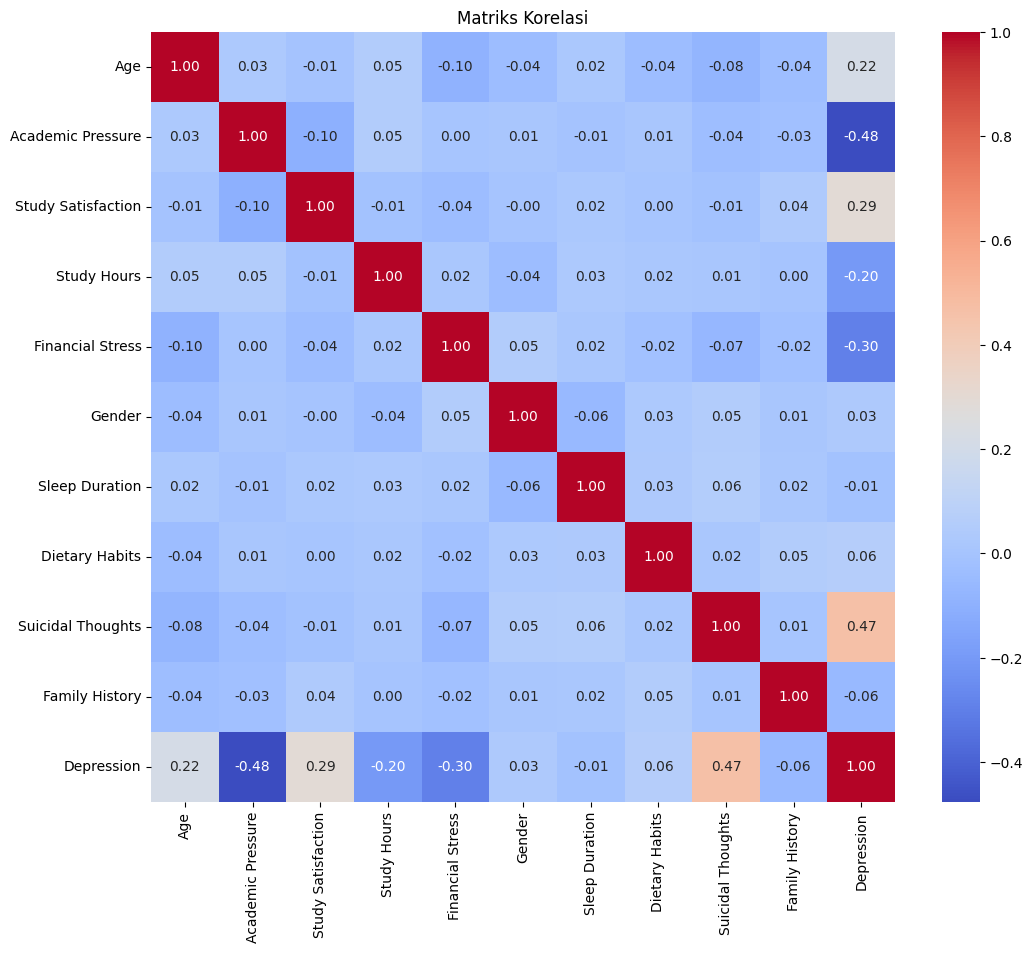

In [ ]:
# visualisasi data menggunakan heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title('Matriks Korelasi')
plt.show()

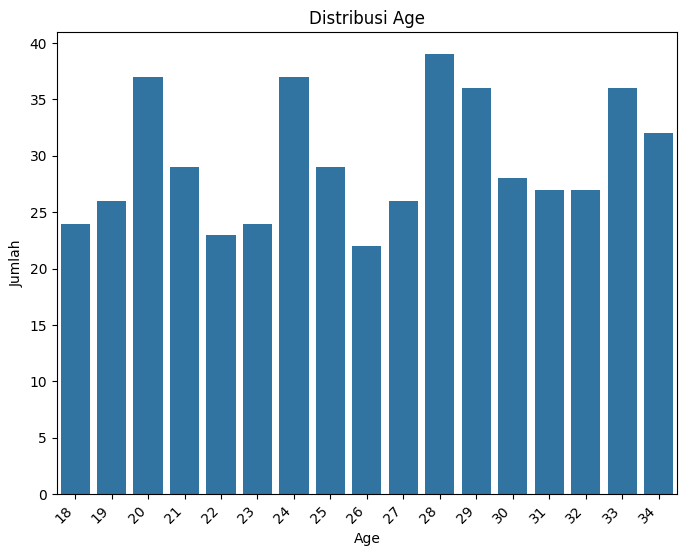

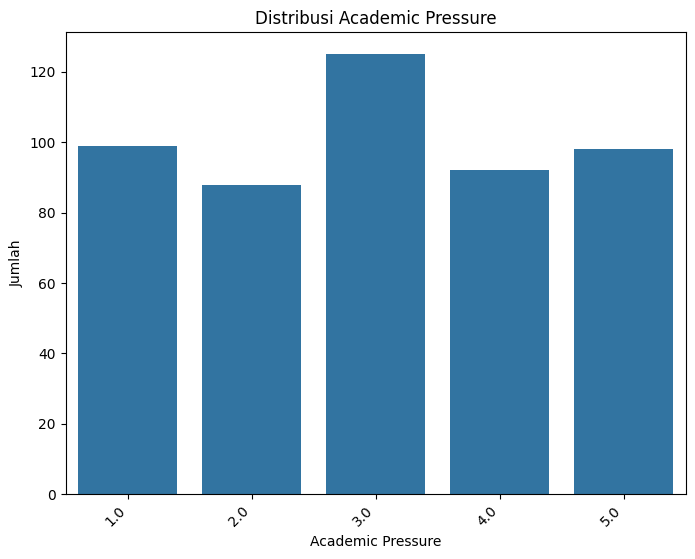

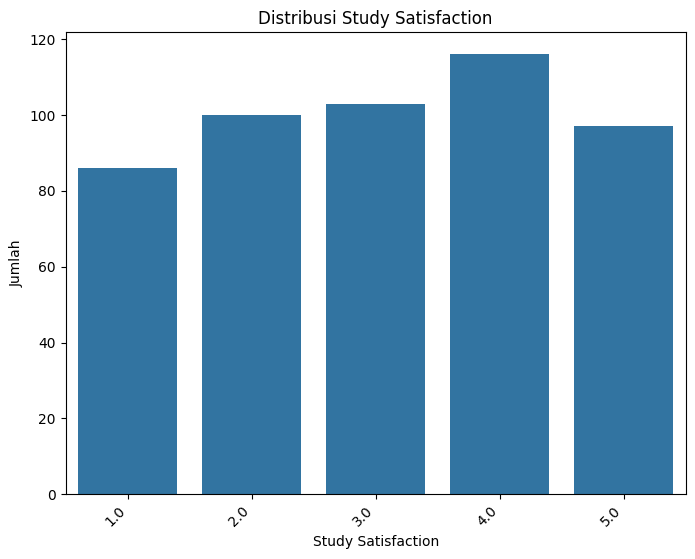

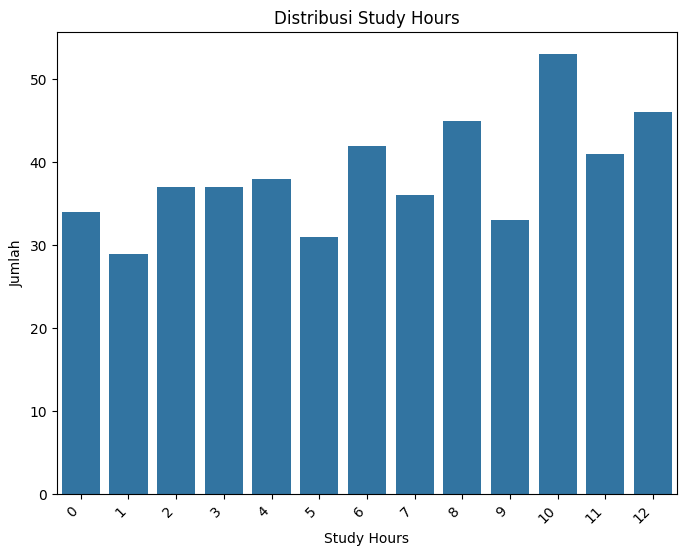

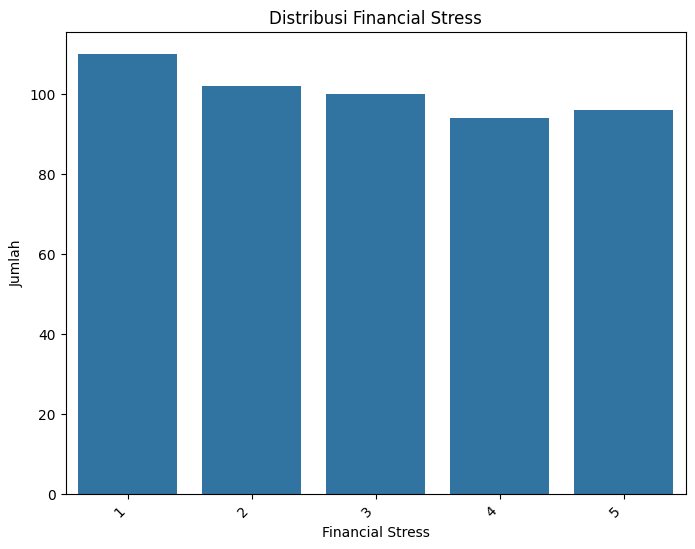

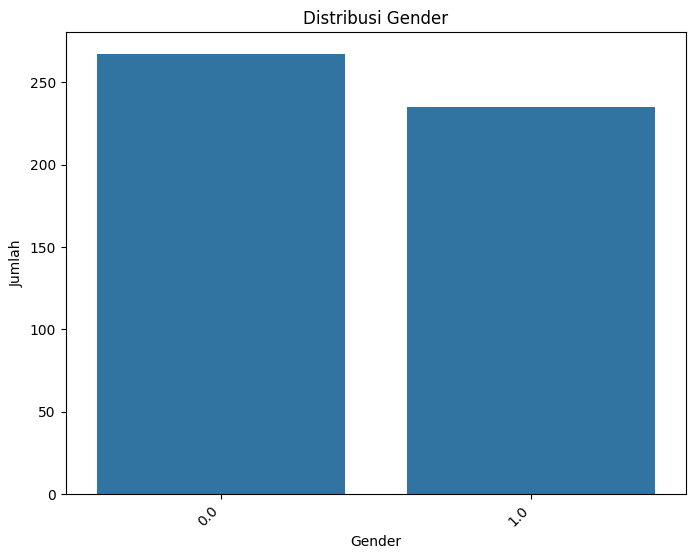

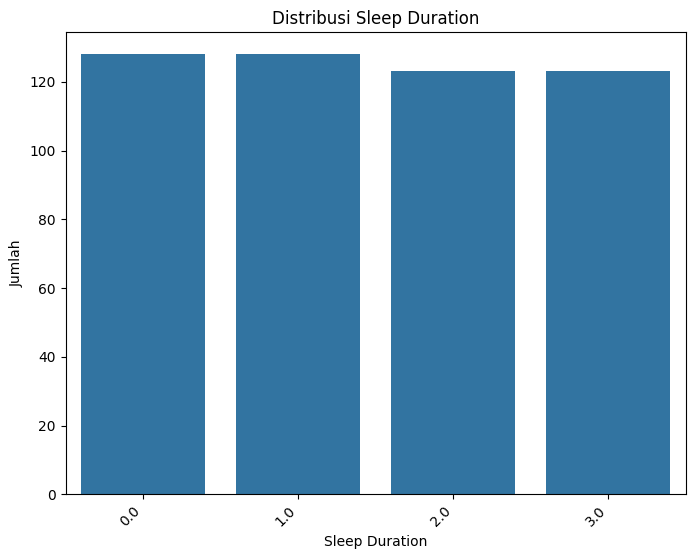

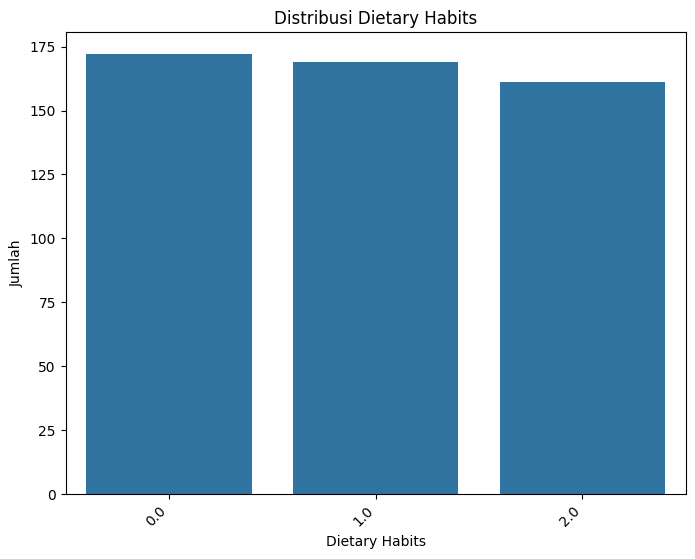

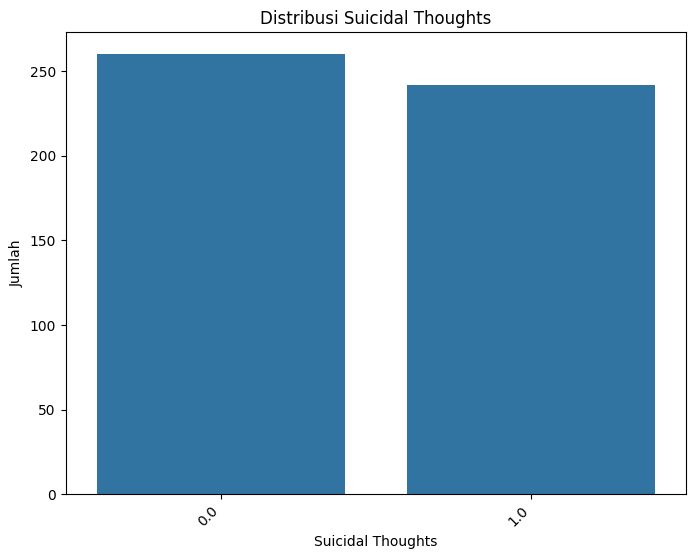

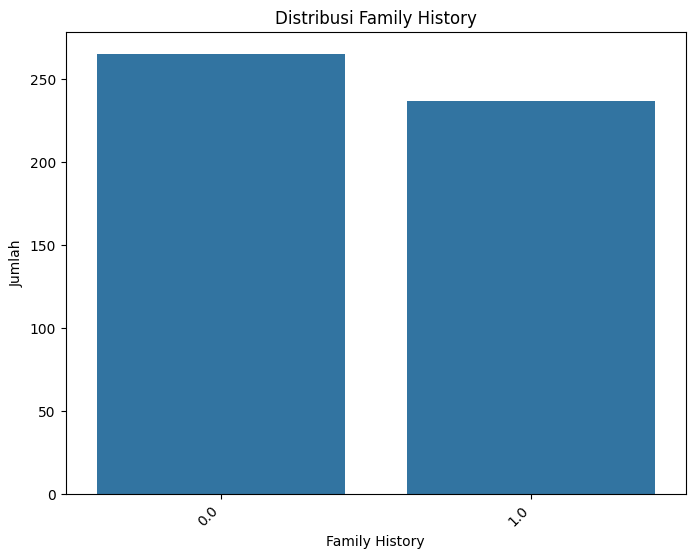

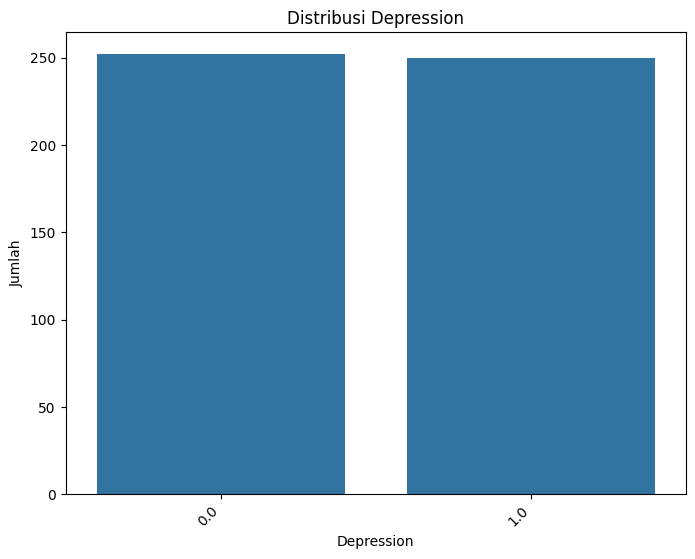

In [ ]:
# Loop melalui semua kolom dalam DataFrame
for column in df.columns:
    # Mengambil data untuk kolom saat ini
    column_data = df.select(column).toPandas()

    # Membuat bar chart menggunakan seaborn dan matplotlib
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=column_data)
    plt.title(f'Distribusi {column}')
    plt.xlabel(column)
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x jika diperlukan
    plt.show()



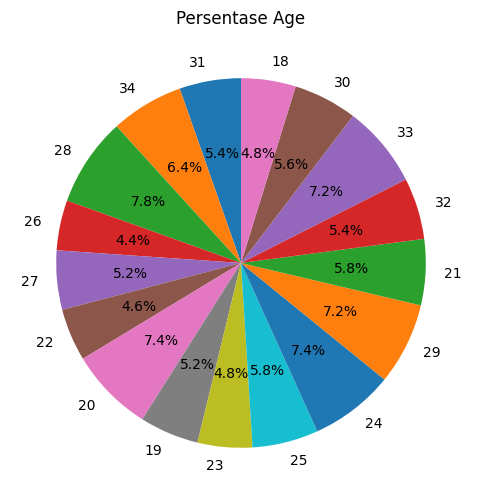

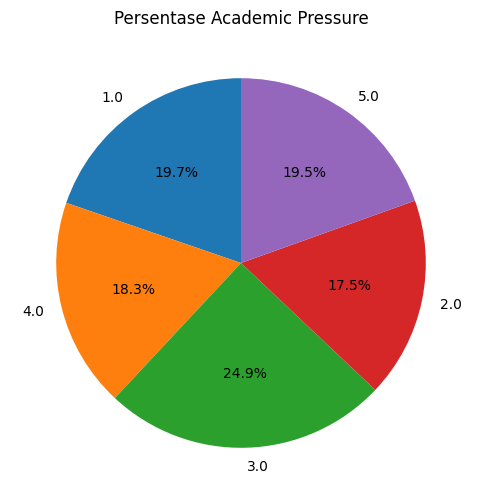

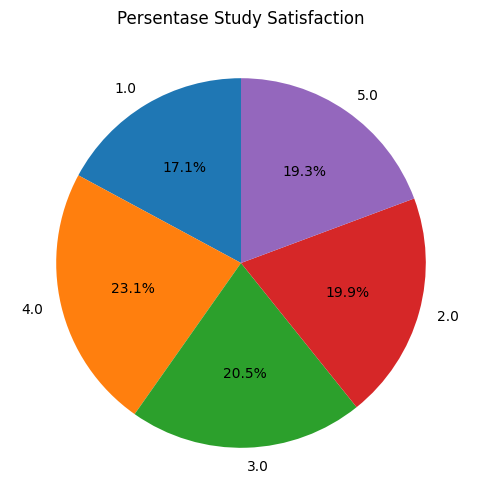

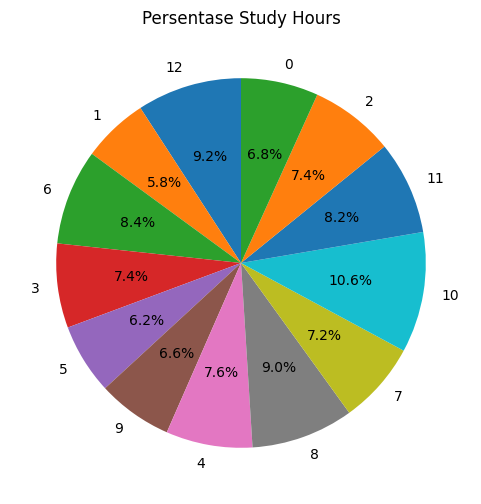

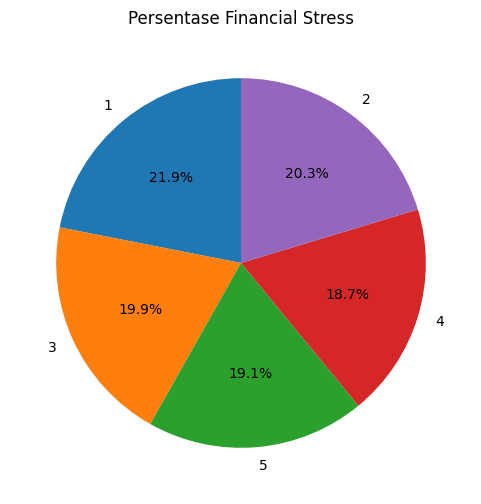

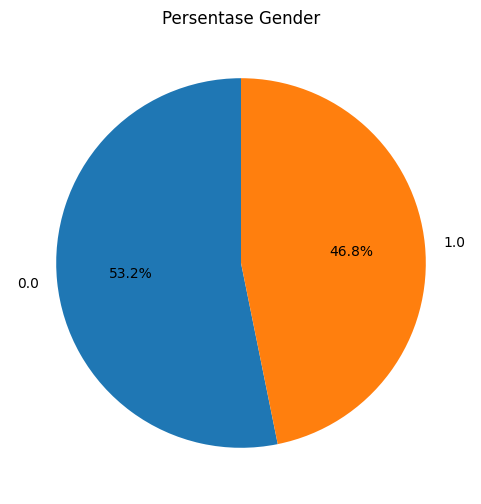

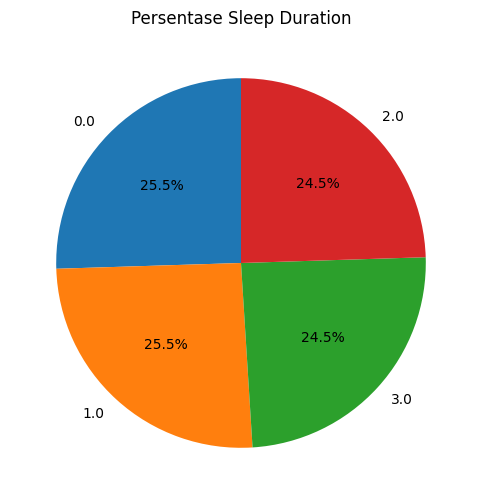

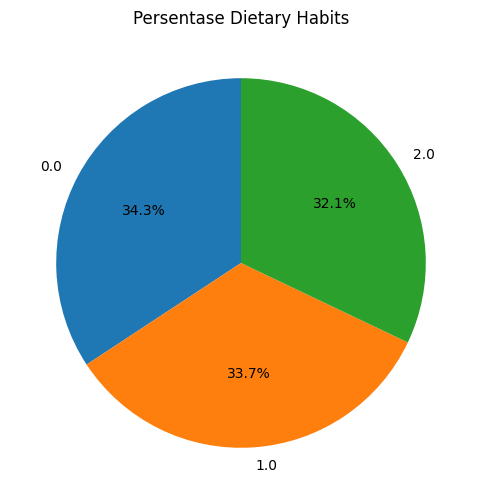

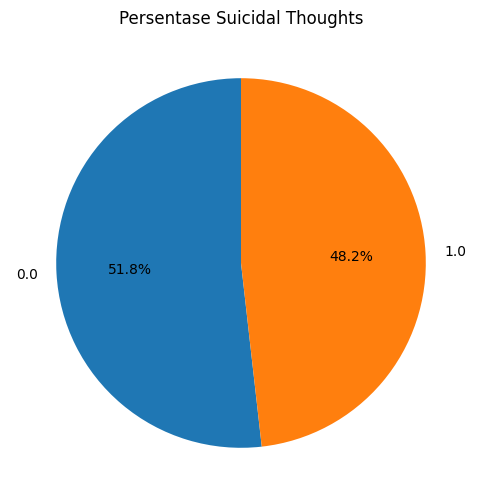

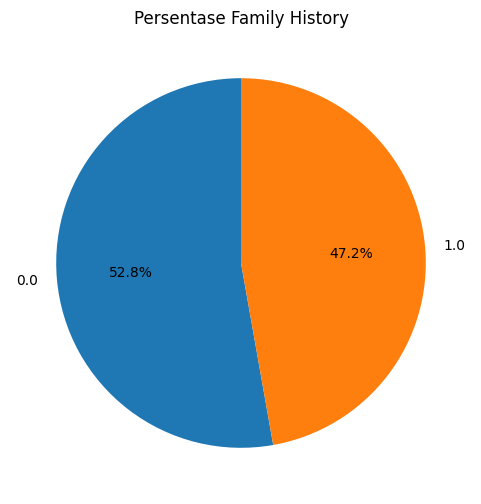

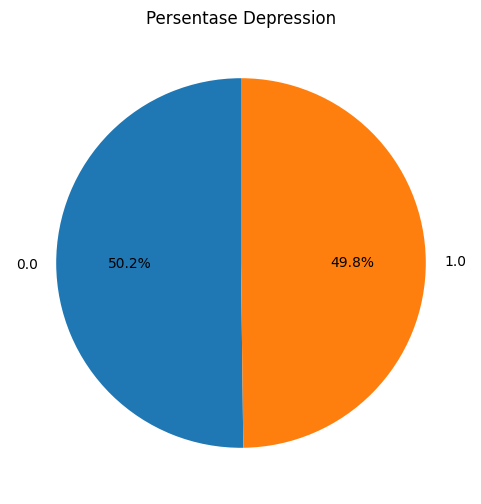

In [ ]:
# Loop melalui semua kolom dalam DataFrame
for column in df.columns:
    # Menghitung frekuensi nilai dalam kolom
    value_counts = df.groupBy(cSolumn).count().toPandas()

    # Membuat pie chart menggunakan matSplotlib
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts["count"], labels=value_counts[column], autopct='%1.1f%%', startangle=90)
    plt.title(f'Persentase {column}')
    plt.show()

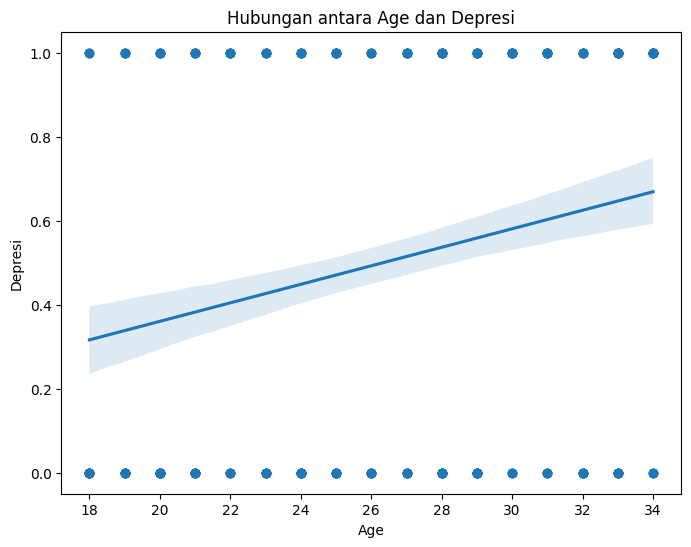

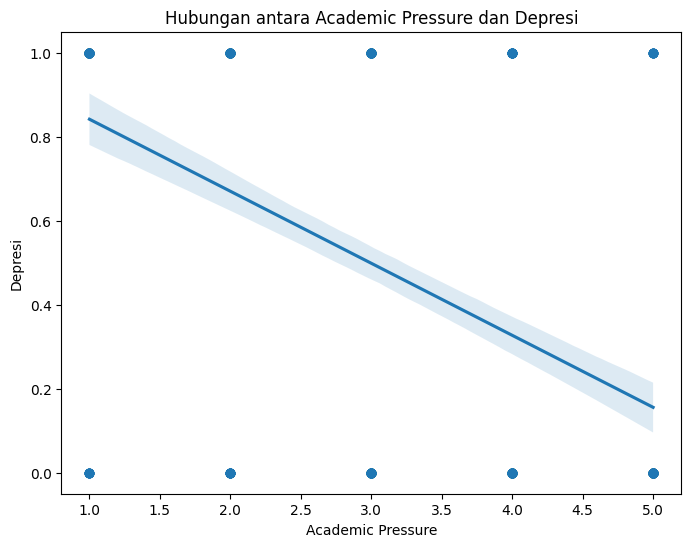

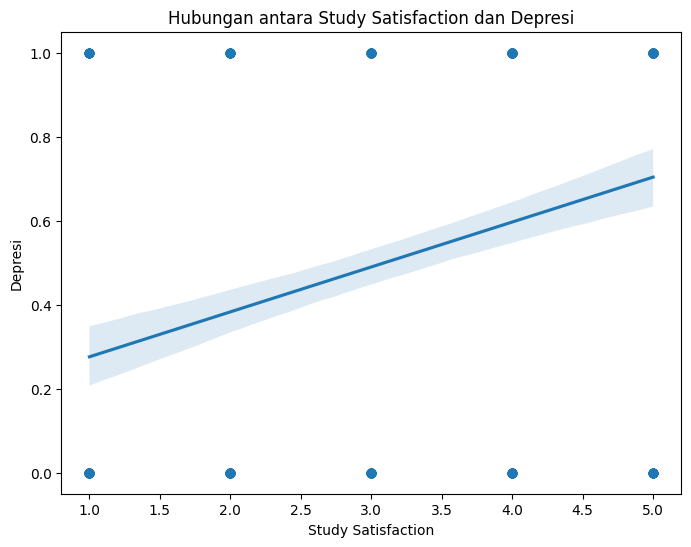

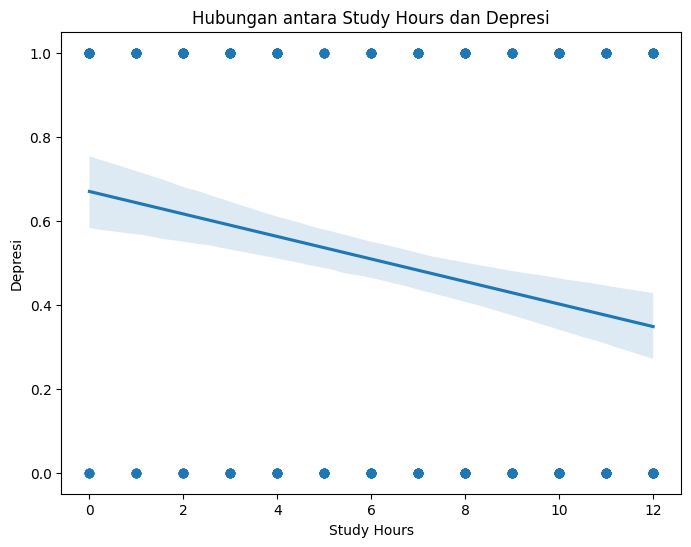

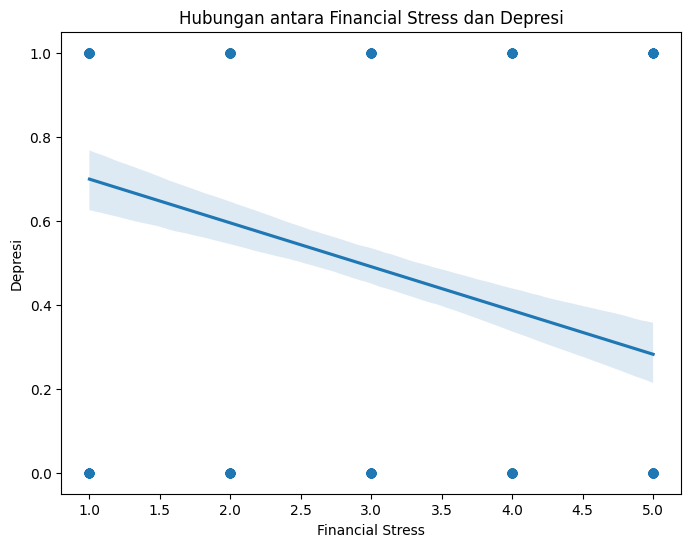

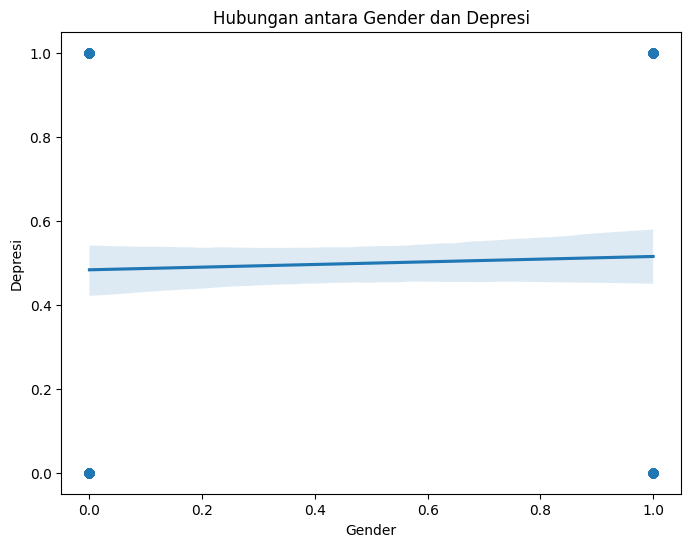

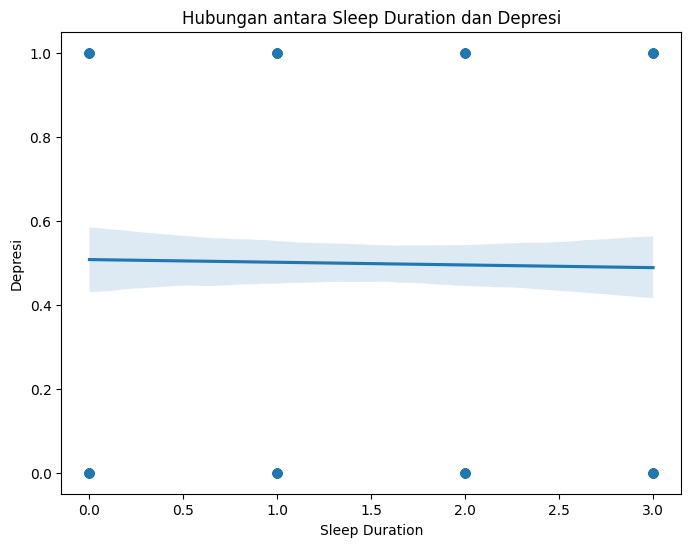

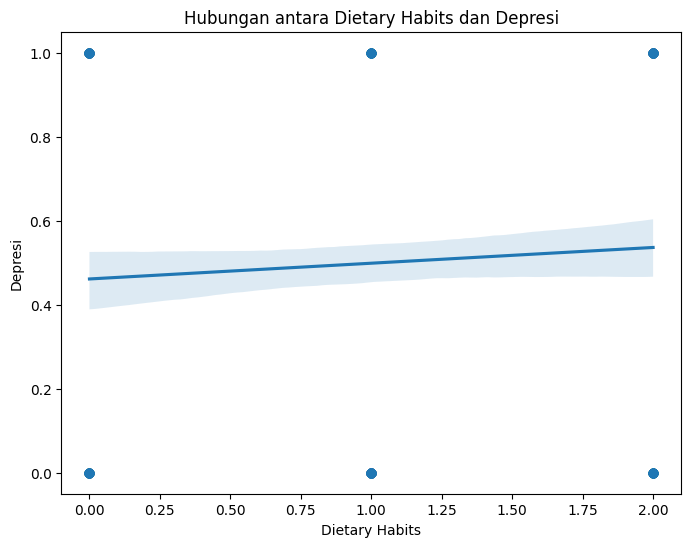

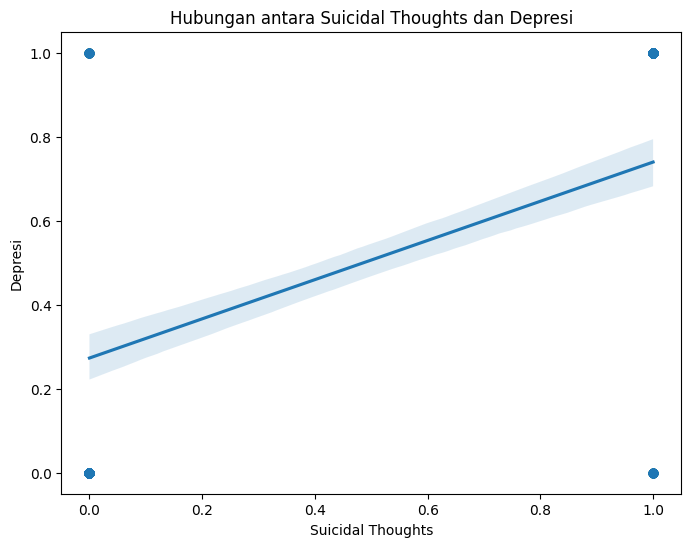

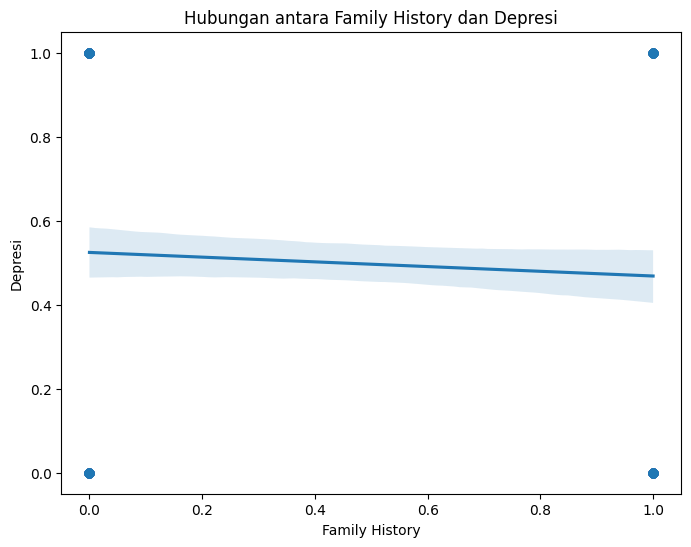

In [ ]:
# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Loop melalui kolom numerik (kecuali 'Depression')
for column in numeric_cols:
    if column != 'Depression':
        # Mengambil data untuk kolom saat ini dan 'Depression'
        data = df.select(column, 'Depression').toPandas()

        # Membuat scatter plot dengan garis regresi menggunakan seaborn dan matplotlib
        plt.figure(figsize=(8, 6))
        sns.regplot(x=column, y='Depression', data=data, scatter_kws={'alpha':0.5})
        plt.title(f'Hubungan antara {column} dan Depresi')
        plt.xlabel(column)
        plt.ylabel('Depresi')
        plt.show()

#untuk melihat korelasi

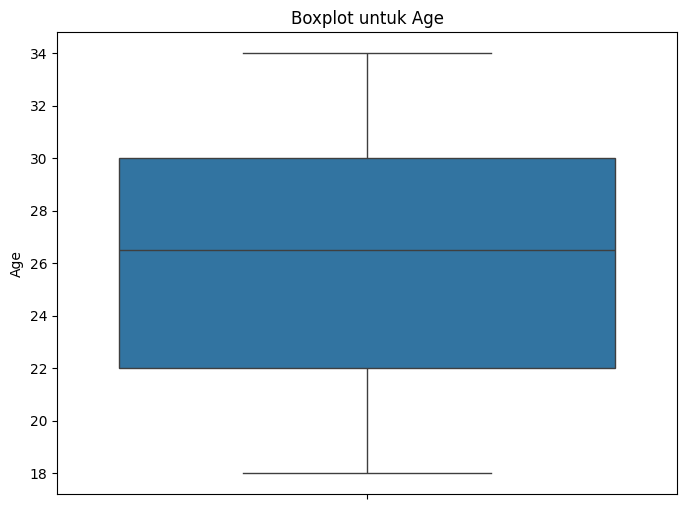

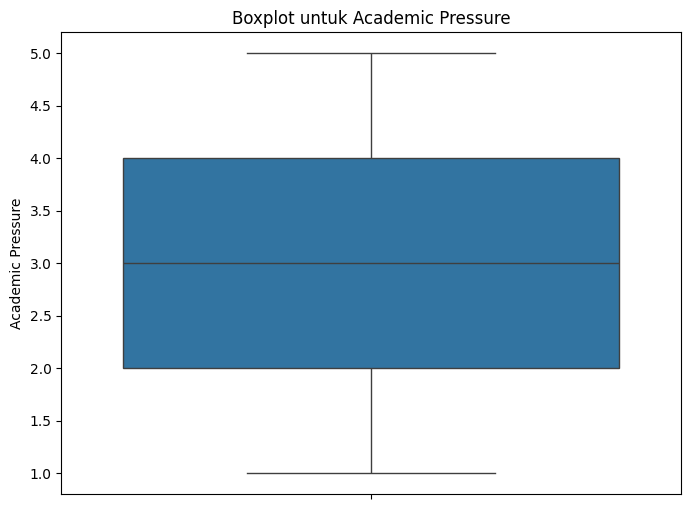

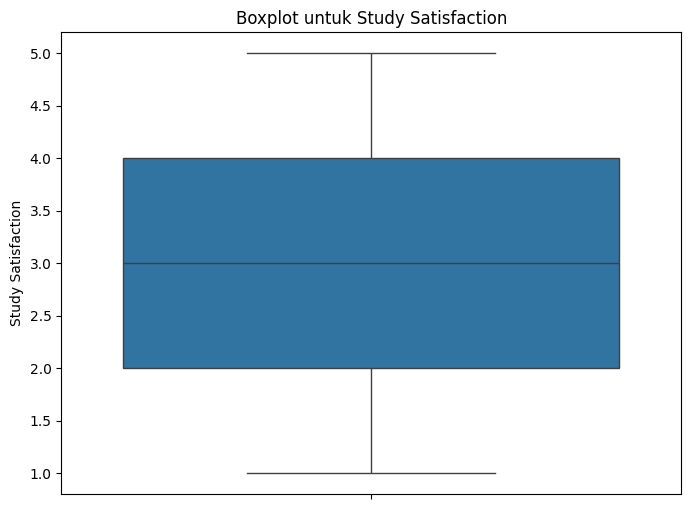

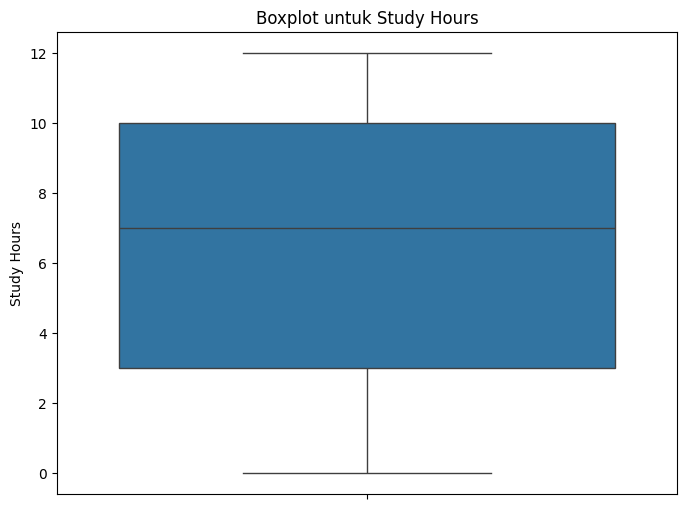

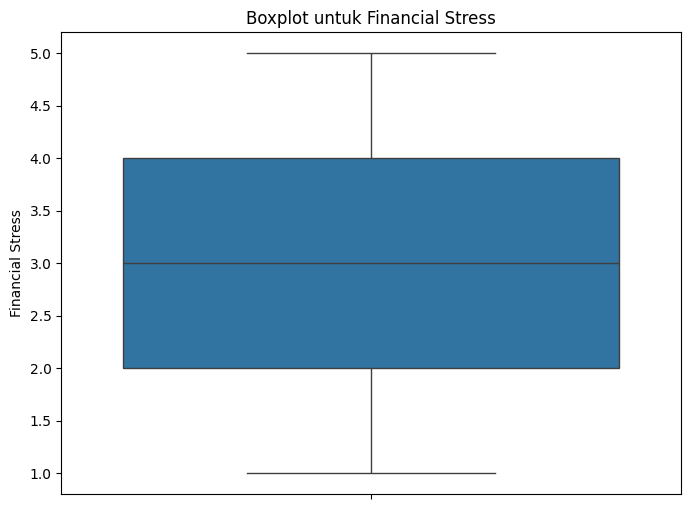

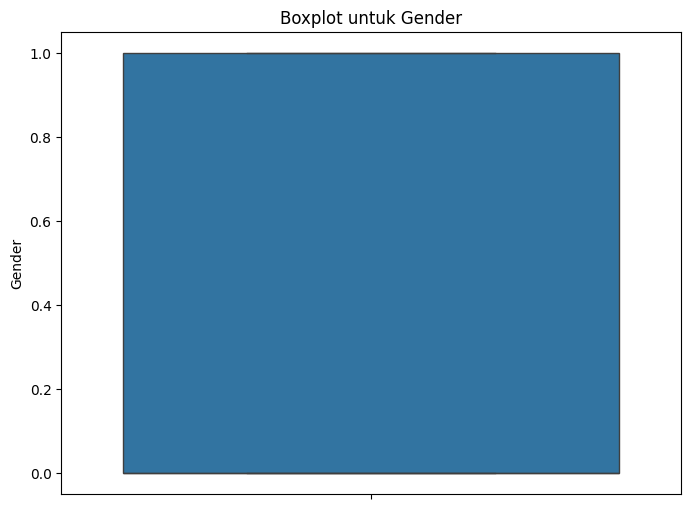

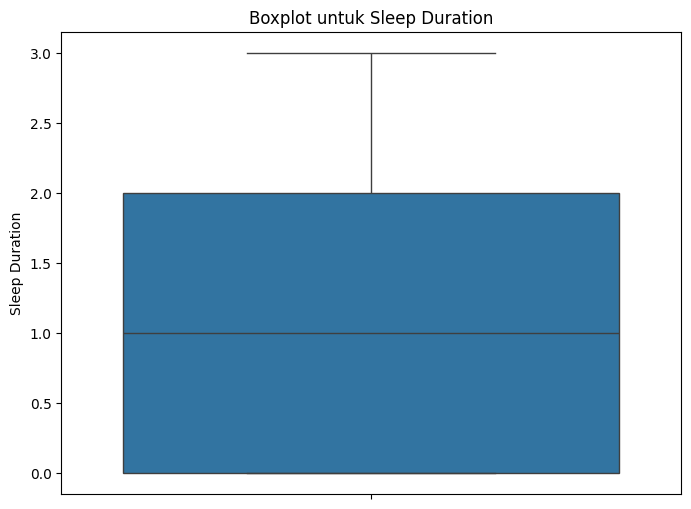

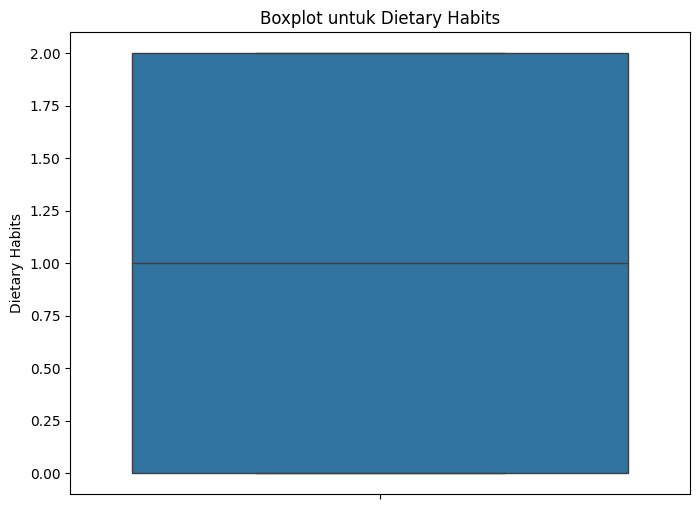

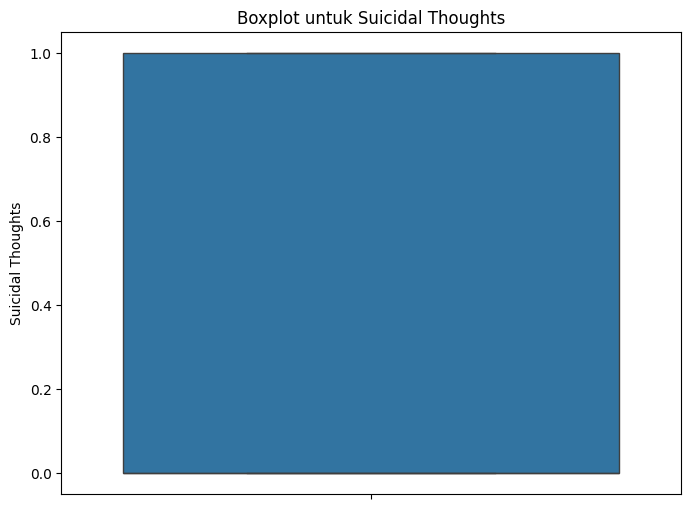

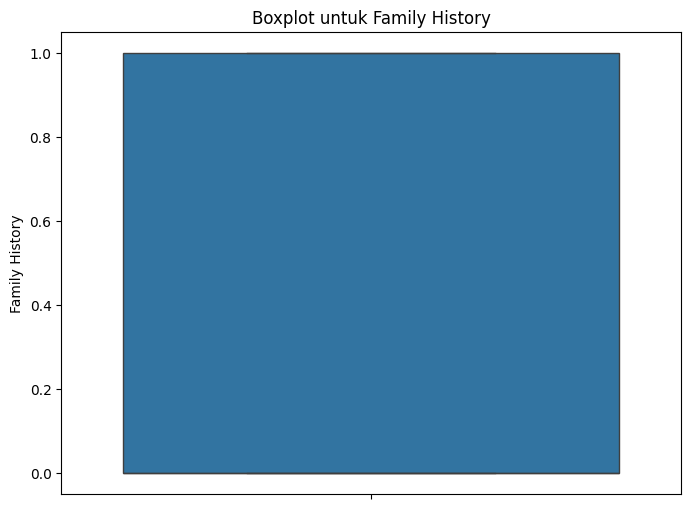

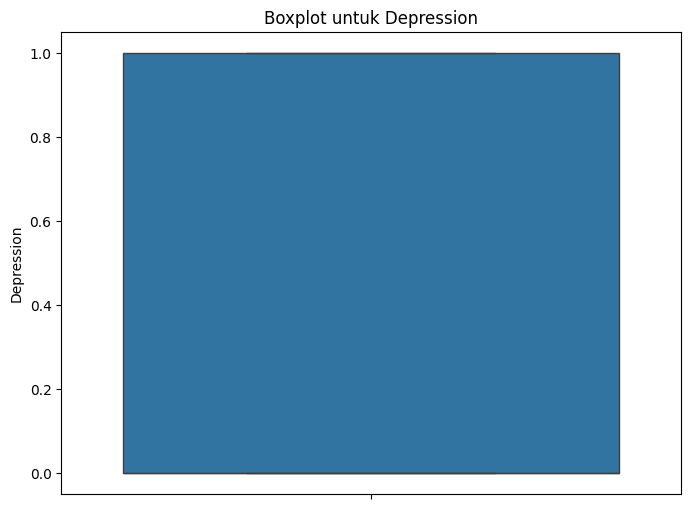

In [ ]:
# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Loop melalui setiap kolom numerik dan buat boxplot terpisah
for column in numeric_cols:
    # Mengambil data untuk kolom saat ini
    column_data = df.select(column).toPandas()

    # Membuat boxplot menggunakan seaborn dan matplotlib
    plt.figure(figsize=(8, 6))  # Mengatur ukuran figure
    sns.boxplot(y=column, data=column_data)  # Membuat boxplot untuk kolom saat ini
    plt.title(f'Boxplot untuk {column}')  # Memberi judul plot dengan nama kolom
    plt.show()  # Menampilkan plot

# Nomor 2

# **Proses Preprocessing Lanjutan**

In [ ]:

from pyspark.sql.functions import col as pyspark_col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.types import NumericType
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes,LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import functions as F
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import pandas as pd
from sklearn.metrics import roc_curve, auc

In [ ]:
spark = SparkSession.builder.appName("ML_Model_Comparison").getOrCreate()

In [ ]:
# Read the CSV file into a PySpark DataFrame
df_machinelearning = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame (optional)
df_machinelearning.show()

+------+---+-----------------+------------------+-----------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|Gender|Age|Academic Pressure|Study Satisfaction|   Sleep Duration|Dietary Habits|Have you ever had suicidal thoughts ?|Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+------+---+-----------------+------------------+-----------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|  Male| 28|              2.0|               4.0|        7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              4.0|               5.0|        5-6 hours|       Healthy|                                  Yes|          7|               1|                             Yes|        No|
|  Male| 25|              1.0|

In [ ]:
data_take = df_machinelearning.limit(5)
transposed_data = data_take.select([pyspark_col(column).alias(str(column)) # Use the renamed col function
for column in data_take.columns]).toPandas().transpose()
print(transposed_data)

                                               0          1          2  \
Gender                                      Male       Male       Male   
Age                                           28         28         25   
Academic Pressure                            2.0        4.0        1.0   
Study Satisfaction                           4.0        5.0        3.0   
Sleep Duration                         7-8 hours  5-6 hours  5-6 hours   
Dietary Habits                          Moderate    Healthy  Unhealthy   
Have you ever had suicidal thoughts ?        Yes        Yes        Yes   
Study Hours                                    9          7         10   
Financial Stress                               2          1          4   
Family History of Mental Illness             Yes        Yes         No   
Depression                                    No         No        Yes   

                                                       3                  4  
Gender                           

In [ ]:
pd.DataFrame(df_machinelearning.take(5), columns=df_machinelearning.columns).transpose()

,0,1,2,3,4
Gender,Male,Male,Male,Male,Female
Age,28,28,25,23,31
Academic Pressure,2.0,4.0,1.0,1.0,1.0
Study Satisfaction,4.0,5.0,3.0,4.0,5.0
Sleep Duration,7-8 hours,5-6 hours,5-6 hours,More than 8 hours,More than 8 hours
Dietary Habits,Moderate,Healthy,Unhealthy,Unhealthy,Healthy
Have you ever had suicidal thoughts ?,Yes,Yes,Yes,Yes,Yes
Study Hours,9,7,10,7,4
Financial Stress,2,1,4,2,2
Family History of Mental Illness,Yes,Yes,No,Yes,Yes


In [ ]:
categoricalColumns = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol='Depression', outputCol='label')
stages += [label_stringIdx]

numericCols = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_machinelearning)
df_transformed = pipelineModel.transform(df_machinelearning)

selectedCols = ['label', 'features'] + df_machinelearning.columns
df_transformed = df_transformed.select(selectedCols)
df_machinelearning = df_transformed
df_machinelearning.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Study Hours: integer (nullable = true)
 |-- Financial Stress: integer (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: string (nullable = true)



# **Modeling**

In [ ]:
train, test = df_machinelearning.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 400
Test Dataset Count: 102


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Gradient Boosting Model
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=10)  # Initialize GBT model
model_gbt = gbt.fit(train)  # Train GBT model

# Make predictions on the test data
predictions_gbt = model_gbt.transform(test)
# Evaluate the Model (Accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator.evaluate(predictions_gbt)
print("Accuracy (Gradient Boosting) = %g" % accuracy_gbt)

# Evaluate the Model (F1 Score)
evaluator.setMetricName("f1")
f1_score_gbt = evaluator.evaluate(predictions_gbt)
print("F1 Score (Gradient Boosting) = %g" % f1_score_gbt)

evaluator.setMetricName("weightedPrecision")
precision_rf = evaluator.evaluate(predictions_gbt)
print("Precision (Gradient Boosting = %g" % precision_rf)

evaluator.setMetricName("weightedRecall")
recall_rf = evaluator.evaluate(predictions_gbt)
print("Recall (Gradient Boosting) = %g" % recall_rf)

Accuracy (Gradient Boosting) = 0.872549
F1 Score (Gradient Boosting) = 0.872882
Precision (Gradient Boosting = 0.874728
Recall (Gradient Boosting) = 0.872549


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10)  # Initialize RF model
model_rf = rf.fit(train)
# Make predictions on the test data
predictions_rf = model_rf.transform(test)

# Evaluate the Model (Accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Accuracy (Random Forest) = %g" % accuracy_rf)

# Evaluate the Model (F1 Score)
evaluator.setMetricName("f1")
f1_score_rf = evaluator.evaluate(predictions_rf)
print("F1 Score (Random Forest) = %g" % f1_score_rf)

evaluator.setMetricName("weightedPrecision")
precision_rf = evaluator.evaluate(predictions_rf)
print("Precision (Random Forest) = %g" % precision_rf)

evaluator.setMetricName("weightedRecall")
recall_rf = evaluator.evaluate(predictions_rf)
print("Recall (Random Forest) = %g" % recall_rf)

Accuracy (Random Forest) = 0.882353
F1 Score (Random Forest) = 0.882353
Precision (Random Forest) = 0.882353
Recall (Random Forest) = 0.882353


In [ ]:
# Inisialisasi Naive Bayes
nb = NaiveBayes(featuresCol='features', labelCol='label', smoothing=30)

# Latih model dengan data training
model_nb = nb.fit(train)

# Prediksi data testing
predictions_nb = model_nb.transform(test)

# Evaluasi Akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_nb = evaluator.evaluate(predictions_nb)
print(f"Accuracy (Naive Bayes) = {accuracy_nb}")

# Evaluasi F1-Score
evaluator.setMetricName("f1")
f1_score_nb = evaluator.evaluate(predictions_nb)
print(f"F1 Score (Naive Bayes) = {f1_score_nb}")

evaluator.setMetricName("weightedPrecision")
precision_nb = evaluator.evaluate(predictions_nb)
print("Precision (Random Forest) = %g" % precision_nb)

evaluator.setMetricName("weightedRecall")
recall_nb = evaluator.evaluate(predictions_nb)
print("Recall (Random Forest) = %g" % recall_nb)

Accuracy (Naive Bayes) = 0.8627450980392157
F1 Score (Naive Bayes) = 0.8631679086729032
Precision (Random Forest) = 0.874221
Recall (Random Forest) = 0.862745


In [ ]:
# Inisialisasi model LinearSVC (SVM)
svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10)

# Latih model
svm_model = svm.fit(train)

# Prediksi
predictions_svm = svm_model.transform(test)

# Evaluasi Akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_svm = evaluator.evaluate(predictions_svm)
print(f"Accuracy (SVM) = {accuracy_svm}")

# Evaluasi F1-Score
evaluator.setMetricName("f1")
f1_score_svm = evaluator.evaluate(predictions_svm)
print(f"F1 Score (SVM) = {f1_score_svm}")

# Calculate Precision and Recall
evaluator.setMetricName("weightedPrecision")  # For precision
precision_svm = evaluator.evaluate(predictions_svm)
print(f"Precision (SVM) = {precision_svm}")

evaluator.setMetricName("weightedRecall")  # For recall
recall_svm = evaluator.evaluate(predictions_svm)
print(f"Recall (SVM) = {recall_svm}")

Accuracy (SVM) = 0.9607843137254902
F1 Score (SVM) = 0.9608604311289732
Precision (SVM) = 0.9616793719422003
Recall (SVM) = 0.9607843137254902


# **AUC & ROC**

gbt Model AUC: 0.932


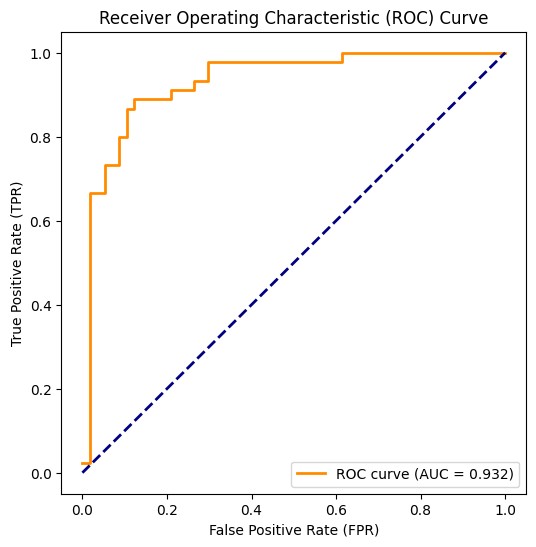

In [ ]:
from sklearn.metrics import auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt

# Ekstrak probabilitas prediksi
predictions_gbt = predictions_gbt.withColumn("probability_array", vector_to_array("probability"))

# Evaluator untuk menghitung AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions_gbt)
print(f"gbt Model AUC: {auc_score:.3f}")

# Hitung ROC secara manual
roc_data = predictions_gbt.select("label", "probability_array").rdd \
    .map(lambda row: (float(row["probability_array"][1]), float(row["label"]))) \
    .toDF(["probability", "label"])

roc_pd = pd.DataFrame(roc_data.sort("probability", ascending=False).toPandas())
roc_pd = roc_pd.sort_values(by="probability", ascending=False)  # Pastikan sorting benar
roc_pd['TPR'] = roc_pd['label'].cumsum() / roc_pd['label'].sum()  # TPR
roc_pd['FPR'] = ((1 - roc_pd['label']).cumsum()) / (1 - roc_pd['label']).sum()  # FPR

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(roc_pd['FPR'], roc_pd['TPR'], color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

RF Model AUC: 0.970


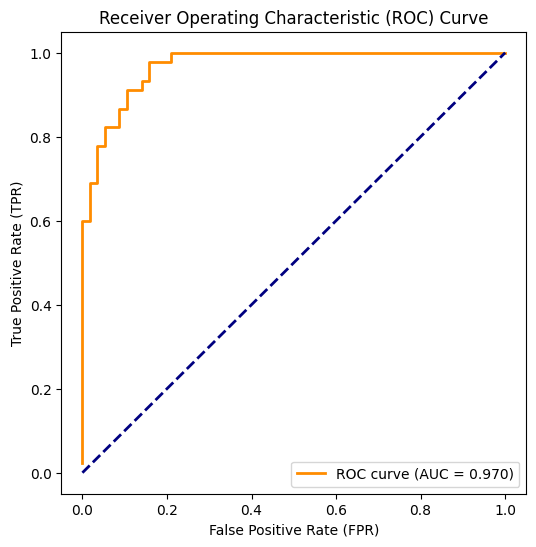

In [ ]:
from sklearn.metrics import auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt

# Ekstrak probabilitas prediksi
predictions_rf = predictions_rf.withColumn("probability_array", vector_to_array("probability"))

# Evaluator untuk menghitung AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions_rf)
print(f"RF Model AUC: {auc_score:.3f}")

# Hitung ROC secara manual
roc_data = predictions_rf.select("label", "probability_array").rdd \
    .map(lambda row: (float(row["probability_array"][1]), float(row["label"]))) \
    .toDF(["probability", "label"])

roc_pd = pd.DataFrame(roc_data.sort("probability", ascending=False).toPandas())
roc_pd = roc_pd.sort_values(by="probability", ascending=False)  # Pastikan sorting benar
roc_pd['TPR'] = roc_pd['label'].cumsum() / roc_pd['label'].sum()  # TPR
roc_pd['FPR'] = ((1 - roc_pd['label']).cumsum()) / (1 - roc_pd['label']).sum()  # FPR

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(roc_pd['FPR'], roc_pd['TPR'], color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NB Model AUC: 0.960233918128655


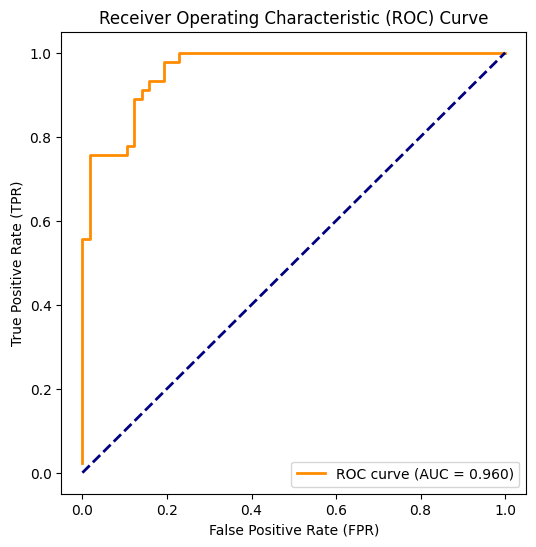

In [ ]:
from sklearn.metrics import auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt

# Ekstrak probabilitas prediksi
predictions_nb = predictions_nb.withColumn("probability_array", vector_to_array("probability"))

# Evaluator untuk menghitung AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions_nb)
print(f"NB Model AUC: {auc_score}")

# Hitung ROC secara manual
roc_data = predictions_nb.select("label", "probability_array").rdd \
    .map(lambda row: (float(row["probability_array"][1]), float(row["label"]))) \
    .toDF(["probability", "label"])

roc_pd = pd.DataFrame(roc_data.sort("probability", ascending=False).toPandas())
roc_pd = roc_pd.sort_values(by="probability", ascending=False)  # Pastikan sorting benar
roc_pd['TPR'] = roc_pd['label'].cumsum() / roc_pd['label'].sum()  # TPR
roc_pd['FPR'] = ((1 - roc_pd['label']).cumsum()) / (1 - roc_pd['label']).sum()  # FPR


# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(roc_pd['FPR'], roc_pd['TPR'], color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

AUC (LinearSVC): 0.9994746716697936


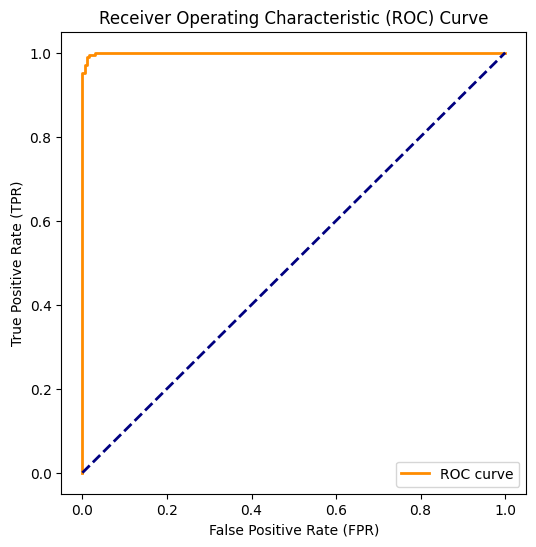

In [ ]:
from sklearn.metrics import auc
trainingSummary = svm_model.summary
summary_object = trainingSummary()  # Call to get the summary object
roc = summary_object.roc.toPandas()

# Calculate AUC (using imported 'auc' function)
roc_auc_score = auc(roc['FPR'], roc['TPR'])
print(f"AUC (LinearSVC): {roc_auc_score}")
# Rest of your code for plotting the ROC curve remains the same
plt.figure(figsize=(6, 6))
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# **Hyperparameter Tuning**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Inisialisasi model LinearSVC (SVM)
svm = LinearSVC(featuresCol='features', labelCol='label')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 15]) \
    .addGrid(svm.regParam, [0.01, 0.05]) \
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create a CrossValidator
cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)  # Use 3 folds for cross-validation

# Fit the model with hyperparameter tuning
cvModel = cv.fit(train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictions_svm1 = bestModel.transform(test)

# Evaluate the best model
accuracy_svm = evaluator.evaluate(predictions_svm1)
print(f"Accuracy (SVM) = {accuracy_svm}")

evaluator.setMetricName("f1")
f1_score_svm = evaluator.evaluate(predictions_svm1)
print(f"F1 Score (SVM) = {f1_score_svm}")

# Calculate Precision and Recall
evaluator.setMetricName("weightedPrecision")  # For precision
precision_svm = evaluator.evaluate(predictions_svm1)
print(f"Precision (SVM) = {precision_svm}")

evaluator.setMetricName("weightedRecall")  # For recall
recall_svm = evaluator.evaluate(predictions_svm1)
print(f"Recall (SVM) = {recall_svm}")
# Prediksi pada data pelatihan
predictions_train = bestModel.transform(train)

Accuracy (SVM) = 0.9901960784313726
F1 Score (SVM) = 0.9902065659483672
Precision (SVM) = 0.9904092071611252
Recall (SVM) = 0.9901960784313726


AUC (LinearSVC): 0.9994246404002501


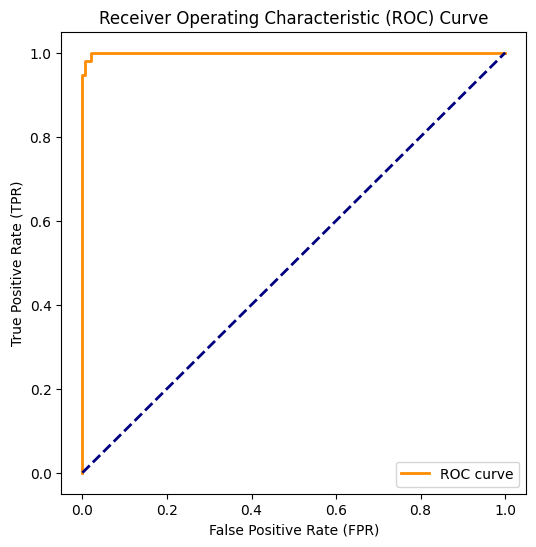

In [ ]:
from sklearn.metrics import auc
trainingSummary = bestModel.summary
summary_object = trainingSummary()  # Call to get the summary object
roc = summary_object.roc.toPandas()

# Calculate AUC (using imported 'auc' function)
roc_auc_score = auc(roc['FPR'], roc['TPR'])
print(f"AUC (LinearSVC): {roc_auc_score}")
# Rest of your code for plotting the ROC curve remains the same
plt.figure(figsize=(6, 6))
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Create parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 50])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 15])   # Maximum depth of trees
             .addGrid(rf.maxBins, [32, 64])       # Maximum bins for splitting
             .build())

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Setup CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

# Fit the model using cross-validation
cvModel = crossval.fit(train)

# Best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on test data
predictions_rf = bestModel.transform(test)

# Evaluate final model
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Best Model Accuracy (Random Forest) = %g" % accuracy_rf)

# Evaluate F1 Score
evaluator.setMetricName("f1")
f1_score_rf = evaluator.evaluate(predictions_rf)
print("Best Model F1 Score (Random Forest) = %g" % f1_score_rf)

# Calculate Precision and Recall
evaluator.setMetricName("weightedPrecision")  # For precision
precision_rf = evaluator.evaluate(predictions_rf)
print(f"Precision (Random Forest)  = {precision_svm}")

evaluator.setMetricName("weightedRecall")  # For recall
recall_rf = evaluator.evaluate(predictions_rf)
print(f"Recall (Random Forest)  = {recall_svm}")

Best Model Accuracy (Random Forest) = 0.892157
Best Model F1 Score (Random Forest) = 0.89202
Precision (Random Forest)  = 0.9904092071611252
Recall (Random Forest)  = 0.9901960784313726


NB Model AUC: 0.9719298245614035


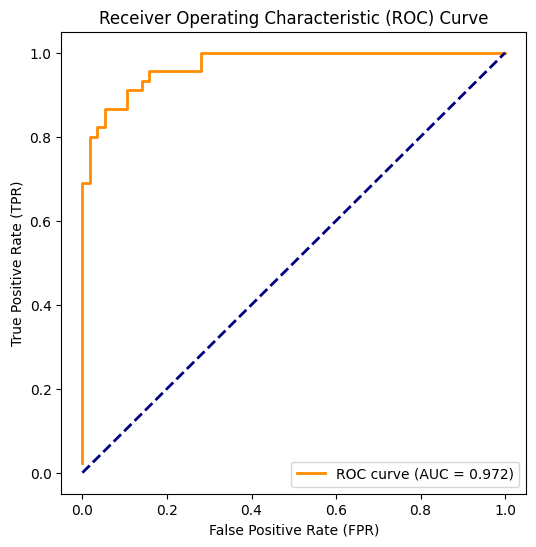

In [ ]:
from sklearn.metrics import auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt

# Ekstrak probabilitas prediksi
predictions_rf = predictions_rf.withColumn("probability_array", vector_to_array("probability"))

# Evaluator untuk menghitung AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions_rf)
print(f"NB Model AUC: {auc_score}")

# Hitung ROC secara manual
roc_data = predictions_rf.select("label", "probability_array").rdd \
    .map(lambda row: (float(row["probability_array"][1]), float(row["label"]))) \
    .toDF(["probability", "label"])

roc_pd = pd.DataFrame(roc_data.sort("probability", ascending=False).toPandas())
roc_pd = roc_pd.sort_values(by="probability", ascending=False)  # Pastikan sorting benar
roc_pd['TPR'] = roc_pd['label'].cumsum() / roc_pd['label'].sum()  # TPR
roc_pd['FPR'] = ((1 - roc_pd['label']).cumsum()) / (1 - roc_pd['label']).sum()  # FPR


# Plot ROC CurveS
plt.figure(figsize=(6, 6))
plt.plot(roc_pd['FPR'], roc_pd['TPR'], color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()